# Convolutional neural networks
This notebook uses the `hybridmodels-modelbuild` virtual environment.

In [313]:
from os.path import join
import glob
from itertools import compress

import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# functions to get dimensions to create node feature matrices for grid
def get_rows_and_cols(df, gridsize=500):
    """
    Parameters:
    -----------
    gridsize : float
        length of one side of a square gridcell in grid.
    """
    from shapely.geometry import box
    df_pm = df.to_crs("EPSG:3857")
    bbounds = df_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / gridsize, 0))
    ncols = int(np.round(width  / gridsize, 0))
    return nrows, ncols

def reshape_df(df, nrows, ncols, features):
    df = df.drop("geometry", axis=1)
    feature_mat = np.empty(shape=(nrows, ncols, len(features)), dtype="float")
    for i, feature in enumerate(features):
        feature_arr = df[feature].values.reshape(nrows, ncols, order="F")
        feature_mat[:, :, i] = feature_arr
    return feature_mat

## Load and parse data

In [327]:
# load the data
wd = join("..", "data", "indata_new")
features = ['gebco', 'fabdem', 'jrc_permwa', 'precip', 'soilcarbon', 'mangrove', 'ndvi', 'wind_avg']
columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]

# separate files based on staggering level
files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
orig_mask = [True if filename.split('.')[-2][-2:] == '_0' else False for filename in files]
plus_mask = [True if filename.split('.')[-2][-4:] == '_250' else False for filename in files]
minus_mask = [True if filename.split('.')[-2][-4:] == '-250' else False for filename in files]
orig = list(compress(files, orig_mask))
plus = list(compress(files, plus_mask))
minus = list(compress(files, minus_mask))

# format event columns
def format_gdf(gdf, filelist):
    l = [gpd.read_file(filename) for filename in filelist]
    gdf = pd.concat(l, axis=0)
    gdf = gdf[columns]

    gdf["event"] = gdf["storm"] + "_" + gdf["region"] + "_" + gdf["subregion"].astype(str)
    gdf = gdf.drop(["storm", "region", "subregion"], axis=1).reset_index(drop=True)

#     # for Gombe-only training
#     gdf['event'] = gdf['event'].str.split('_', expand=True)[2]
#     n = len(gdf.event.unique())
    return gdf

gdf = format_gdf(gdf, orig)
gdf_plus = format_gdf(gdf, plus)
gdf_minus = format_gdf(gdf, minus)


columns.remove("storm")
columns.remove("region")
columns.remove("subregion")

### EDA

<AxesSubplot:>

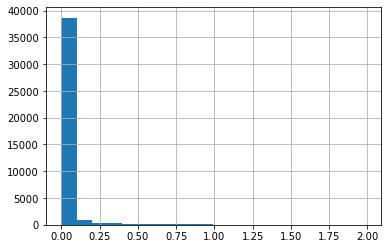

In [316]:
gdf['floodfrac'].hist(bins=20)

In [317]:
print(f"skew: {gdf['floodfrac'].skew()}")
print(f"kurtosis: {gdf['floodfrac'].kurtosis()}")
gdf['floodfrac'].describe()

skew: 7.66909689410825
kurtosis: 76.58341812483111


count    40960.000000
mean         0.022714
std          0.109776
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.988365
Name: floodfrac, dtype: float64

### Format training set
- [ ] random horizontal / vertical flips
- [ ] better viz

In [330]:
# parse the input data to list of 3-d numpy arrays
# TODO: tidy up this cell 
Xmats = []
ymats = []

for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    nrows, ncols = get_rows_and_cols(temp, gridsize=500)
    X = reshape_df(temp, nrows, ncols, features)
    y = reshape_df(temp, nrows, ncols, ["floodfrac"])
    
    # clip to size
    X = X[:64, :64, :]
    y = y[:64, :64, 0]
    
    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y

    Xmats.append(Xmat)
    ymats.append(ymat)

In [332]:
# parse the input data to list of 3-d numpy arrays
# TODO: tidy up this cell 
Xmats = []
ymats = []

for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    nrows, ncols = get_rows_and_cols(temp, gridsize=500)
    X = reshape_df(temp, nrows, ncols, features)
    y = reshape_df(temp, nrows, ncols, ["floodfrac"])
    
    # clip to size
    X = X[:64, :64, :]
    y = y[:64, :64, 0]
    
    a, b, c = X.shape
    Xmat = np.zeros((64, 64, c), dtype=float)
    ymat = np.zeros((64, 64), dtype=float)
    Xmat[:a, :b, :] = X
    ymat[:a, :b] = y

    Xmats.append(Xmat)
    ymats.append(ymat)
    
for event in [*gdf['event'].unique()]:
    temp = gdf_plus[gdf_plus.event==str(event)]
    if len(temp) > 0:
        nrows, ncols = get_rows_and_cols(temp, gridsize=500)
        X = reshape_df(temp, nrows, ncols, features)
        y = reshape_df(temp, nrows, ncols, ["floodfrac"])

        # clip to size
        X = X[:64, :64, :]
        y = y[:64, :64, 0]

        a, b, c = X.shape
        Xmat = np.zeros((64, 64, c), dtype=float)
        ymat = np.zeros((64, 64), dtype=float)
        Xmat[:a, :b, :] = X
        ymat[:a, :b] = y

        Xmats.append(Xmat)
        ymats.append(ymat)
        
for event in [*gdf['event'].unique()]:
    if len(temp) > 0:
        temp = gdf_minus[gdf_minus.event==str(event)]
        nrows, ncols = get_rows_and_cols(temp, gridsize=500)
        X = reshape_df(temp, nrows, ncols, features)
        y = reshape_df(temp, nrows, ncols, ["floodfrac"])

        # clip to size
        X = X[:64, :64, :]
        y = y[:64, :64, 0]

        a, b, c = X.shape
        Xmat = np.zeros((64, 64, c), dtype=float)
        ymat = np.zeros((64, 64), dtype=float)
        Xmat[:a, :b, :] = X
        ymat[:a, :b] = y

        Xmats.append(Xmat)
        ymats.append(ymat)

In [365]:
# create tensorflow datasets with batch size 1
n = len(Xmats)
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats)).shuffle(buffer_size=n).batch(1)
test = data.skip(int(0.9 * n))  # 10% test data
train = data.take(int(0.9 * n))
valid = train.skip(int(0.8 * n)) # 10% valid data
train = train.take(int(0.8 * n)) # 80% train data

print("Training size:", int(0.8 * n))
print("Validation size:", int(0.2 * n))
print("Test size:", int(0.1 * n))

Training size: 19
Validation size: 4
Test size: 2


### View training set

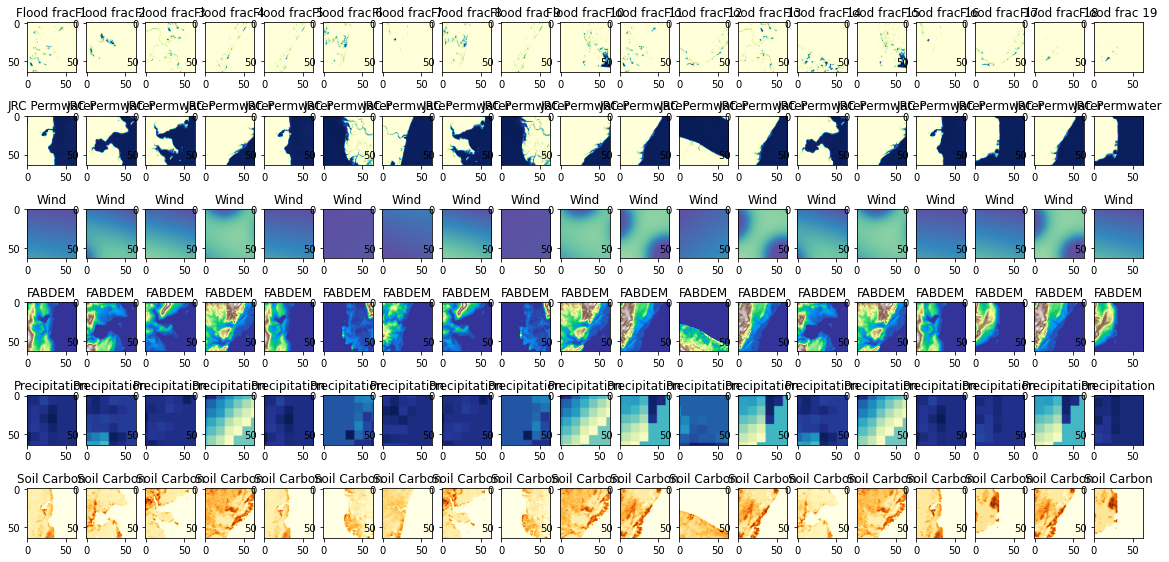

In [343]:
X_train = [element[0].numpy()[0, :, :, :] for element in train]
y_train = [element[1].numpy()[0, :, :] for element in train]

fig, ax = plt.subplots(6, len(y_train), figsize=(20, 10))

for i, im in enumerate(y_train):
    pos = ax[0, i].imshow(im, cmap="YlGnBu")
    ax[0, i].set_title(f"Flood frac {i+1}")
    
for i, im in enumerate(X_train):
    pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
    ax[1, i].set_title("JRC Permwater")

for i, im in enumerate(X_train):
    pos = ax[3, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
    ax[3, i].set_title("FABDEM")

for i, im in enumerate(X_train):
    pos = ax[2, i].imshow(im[:, :, 7], cmap="Spectral_r", vmax=10)
    ax[2, i].set_title("Wind")
    
for i, im in enumerate(X_train):
    pos = ax[4, i].imshow(im[:, :, 3], cmap="YlGnBu", vmin=0)
    ax[4, i].set_title("Precipitation")
    
for i, im in enumerate(X_train):
    pos = ax[5, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
    ax[5, i].set_title("Soil Carbon")

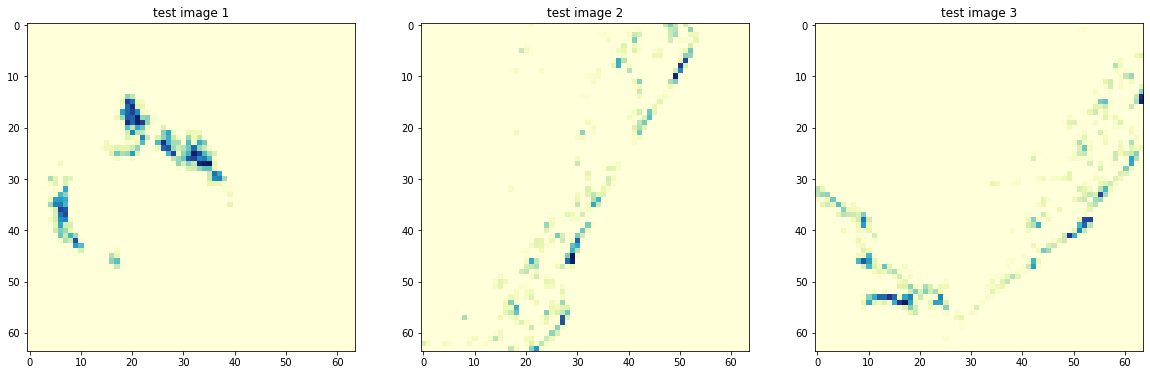

In [344]:
y_test = [element[1].numpy()[0, :, :] for element in test]
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 10))


for i, im in enumerate(y_test):
    pos = ax[i].imshow(im, cmap="YlGnBu")
    ax[i].set_title(f"test image {i+1}")

## U-net style architecture
[Tutorial here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)
### Model hyperparameters
Since the target variable `floodfrac` is very positively-skewed, with many zeros, any Gaussian-assuming loss function such as RMSE can lead to poor results due to zero-inflation. The Tweedie loss function has been developed to deal with this sort of data and is [often used in predicting insurance claims](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). A custom TensorFlow function is provided [here](https://towardsdatascience.com/tweedie-loss-function-for-right-skewed-data-2c5ca470678f). The loss function has the following form,

$$ \mathcal{L} = -\sum_{i} x_i \frac{\hat x_i^{1-p}}{1-p} + \frac{\hat x^{2-p}}{2-p}$$

where $y$ is the trye value, and $\hat y$ is the predicted value. For the optimiser either, stochastic gradient descent with a small (1e-6) learning rate, or else Adam with an adaptive learning rate will be used. Epochs range between 20 and 200 and will need to be explored.
#### Possible future extensions
1. [ ] partialconv padding
2. [ ] dilation to layers

In [345]:
from keras import Sequential
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model

In [346]:
# define the U-Net architecture (from Tutorial)
def double_conv_block(x, depth):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, depth):
    f = double_conv_block(x, depth)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3)):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    # encoder
    f1, p1 = downsample_block(normalized, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

In [355]:
def Tweedie(p):
    def tweedie_loglikelihood(y, y_hat):
        loss = - y * tf.pow(y_hat, 1 - p) / (1 - p) + \
               tf.pow(y_hat, 2 - p) / (2 - p)
        return tf.reduce_mean(loss)
    return tweedie_loglikelihood

unet = build_unet(shape=(64, 64, len(gdf[features].columns)))
unet.compile(optimizer=SGD(learning_rate=1e-3), loss=Tweedie(1.5), metrics="RootMeanSquaredError")
history = unet.fit(train, epochs=20, validation_data=valid, callbacks=EarlyStopping(patience=2))

! say done

Epoch 1/20
19/19 [==============================] - 5s 228ms/step - loss: 0.9086 - root_mean_squared_error: 0.1952 - val_loss: 53.4554 - val_root_mean_squared_error: 0.0953
Epoch 2/20
19/19 [==============================] - 4s 215ms/step - loss: 0.8280 - root_mean_squared_error: 0.1598 - val_loss: 162.2431 - val_root_mean_squared_error: 0.0731
Epoch 3/20
19/19 [==============================] - 4s 213ms/step - loss: 0.7642 - root_mean_squared_error: 0.1414 - val_loss: 135644.0312 - val_root_mean_squared_error: 0.1430


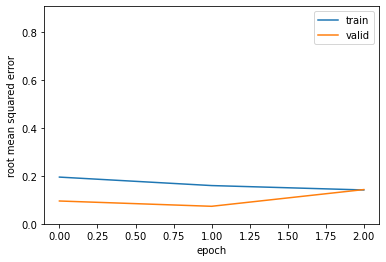

In [356]:
import numpy as np

def plot_history(history):
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('root mean squared error')
    plt.plot(history.epoch, np.array(history.history['root_mean_squared_error']), 
           label='train')
    plt.plot(history.epoch, np.array(history.history['val_root_mean_squared_error']),
           label = 'valid')
    plt.legend()
    plt.ylim([0, max(history.history['loss'])])

plot_history(history)

## Evaluate on test data

In [357]:
[loss, rmse] = unet.evaluate(test, verbose=0)
print("Testing set root mean squared error: {:4.2f}".format(rmse))

Testing set root mean squared error: 0.15


In [358]:
def plot_prediction(test_labels, y_pred, title):
    plt.figure()
    plt.title(title)
    plt.scatter(test_labels, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-100, 100],[-100,100])

    plt.figure()
    error = y_pred - test_labels
    plt.hist(error, bins = 50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")


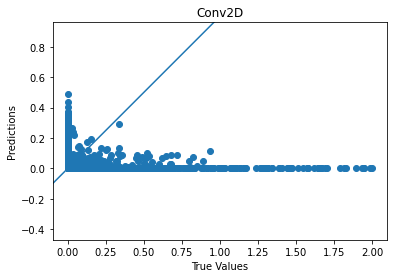

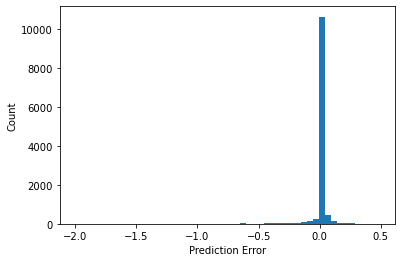

In [359]:
y_pred = unet.predict(test)
plot_prediction(np.array(y_test).flatten(), y_pred.flatten(), "Conv2D")

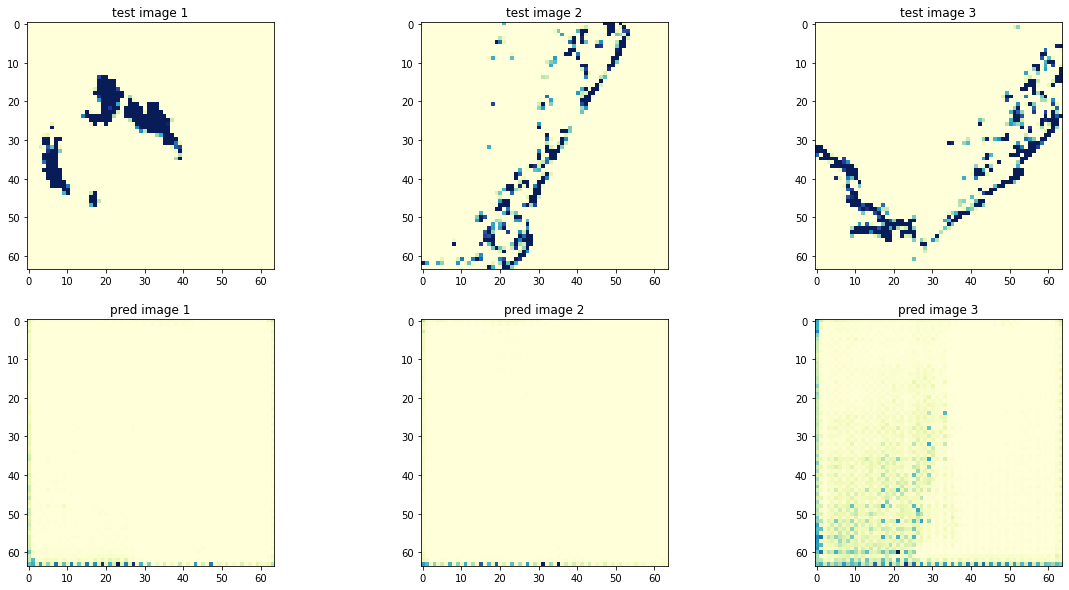

In [360]:
fig, ax = plt.subplots(2, len(y_test), figsize=(20, 10))

for i, im in enumerate(y_test):
    pos = ax[0, i].imshow(im, cmap="YlGnBu", vmin=0, vmax=0.1)
    ax[0, i].set_title(f"test image {i+1}")
    
for i, _ in enumerate(y_test):
    ax[1, i].imshow(y_pred[i, :, :, 0], cmap="YlGnBu")
    ax[1, i].set_title(f"pred image {i+1}")


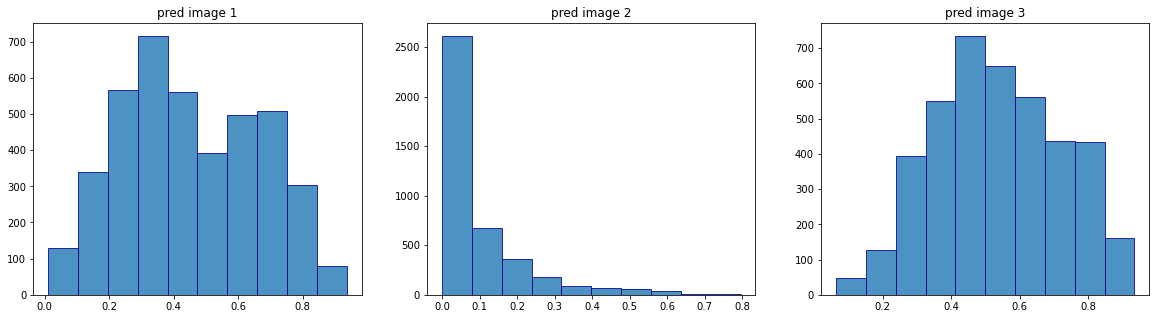

In [354]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 5))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i, :, :, 0].flatten(), alpha=0.8, edgecolor="darkblue")
    ax[i].set_title(f"pred image {i+1}")

In [ ]:
y_pred.shape